In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<b><h1>Function</h1></b>

<b><h2>Anomaly Detection Function</h2></b>

In [2]:
def hotellings_tsqare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) 
    sinv = np.linalg.pinv(trdat.cov())

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

In [3]:
from sklearn.cluster import KMeans
def cbm(trdat, tedat, n_clusters, max_iter):
    '''
    clustering 기반 이상감지 방법론
    clustering 기법으로는 K-means 방법론 사용
    정상구간 내에 있는 클러스터와 test data 간의 t-square를 이상감지 통계량으로 사용
    t-square는 Hotelling's T-square로 마할라노비스 거리랑 동일
    
    @param trdat : train data
    @param tedat : test data
    @param n_clusters : The number of cluster
    @oaran max_iter : max iteration of the K-means clustering
    '''
    km = KMeans(n_clusters=n_clusters,max_iter=max_iter,random_state=0).fit(trdat)
    km_score = km.predict(trdat)
    cluster_df = pd.concat([trdat,pd.DataFrame(km_score, columns=['cluster'])], axis=1)

    # cluster 별 mu, covariance
    k_mu = np.zeros((trdat.shape[1], n_clusters))
    k_cov = np.zeros((n_clusters, trdat.shape[1], trdat.shape[1]))

    for i in range(n_clusters):
        k_mu[:,i] = trdat[cluster_df['cluster'] == i].mean()
        k_cov[i] = trdat[cluster_df['cluster'] == i].cov()

    cbm_mat = np.zeros((len(tedat), n_clusters))
    for i in range(len(tedat)):
        for j in range(n_clusters):
            cbm_mat[i,j] = (tedat.values[i,:] - k_mu[:,j]) @ np.linalg.pinv(k_cov[j]) @ (tedat.values[i,:] - k_mu[:,j]).transpose()
            
    cbm_mat = pd.DataFrame(cbm_mat)
    result = cbm_mat.apply(np.min, axis=1)
    
    return {"cluster_score" : cbm_mat.values, 'cbm':result}

<b><h2>The Search of Optimial CBM Function</h2></b>

In [4]:
def AUC_score(alphaError, betaError):
    '''
    AUC score
    
    @param alphaError : 실제로 양품인데 불량으로 예측한 수/ 전체 양품의 수
    @param betaError : 실제로 불량품인데 양품으로 예측한 수/ 전체 불량품의 수
    '''
    auc = np.sum(np.diff(alphaError)*betaError[1:] + np.diff(alphaError)*np.diff(betaError) / 2)
    return auc

# optimize the number of cluster and ALpha of CBM
def optCBM(trdat, tedat, labels, n_clusters=3):
    '''
    최적의 control limit 산출을 위한 유의수준(alpha)과 CBM에서 최적의 클러스터 개수(k) 탐색 기법
    
    @param trdat : train data
    @param tedat : test data
    @param labels : test data의 label
    @ CBM에서 클러스터의 개수
    '''

    # result_mat : [nclusters, search할 alpha 개수, (alpha, alpha error, beta error)]
    result_mat = np.zeros((n_clusters, 100, 3)) 
    for k in range(n_clusters):
        cbm_model = cbm(trdat, tedat, n_clusters=k+1, max_iter=100)
        healthy_cbm = cbm(trdat, trdat, n_clusters=k+1, max_iter=100)
        for i in range(100):
            alpha = (i+1)/100
            cl = bootstrap_limit(healthy_cbm['cbm'], alpha=alpha)
            alpha_error = sum(labels[np.where(cbm_model['cbm']>cl)[0]] == "Y")/ sum(labels=="Y")
            beta_error = sum(labels[np.where(cbm_model['cbm']<cl)[0]] == "N") / sum(labels=="N")
            result_mat[k,i,0] = alpha 
            result_mat[k,i,1] = alpha_error
            result_mat[k,i,2] = beta_error
            aucScore= AUC_score(result_mat[k][:,1],result_mat[k][:,2]) # AUC_score(alphaError, betaError)
        auc = {'k':(k+1),'AUCScore' : aucScore}
        print('-------------')
        print('k=%d' %auc['k'])
        print('AUC=%f' %round(auc['AUCScore'],4))
        print('-------------')
        
    return result_mat

<b><h2>False Alarm Classification Model Function</h2></b>

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# Optimizied Decision Tree
def optDT(trdatX, trdatY, meausre='f1'):
    clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None)
    clf_dt.fit(trdatX, trdatY)

    params = {'max_depth' : np.arange(5,30)}
    grid_cv = GridSearchCV(clf_dt, param_grid=params, scoring=meausre, cv=5, verbose=1)
    grid_cv.fit(trdatX,trdatY )
    
    print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
    print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

    # pruning 한 모델
    best_df_clf = grid_cv.best_estimator_
    
    return best_df_clf

<b><h2>Bootstrap Based Control Limit Function</h2></b>

In [6]:
def bootstrap_limit(stat, alpha=0.05, bootstrap=100):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    return limit

<b><h2>Visualization Function</h2></b>

In [7]:
# visualization code of Anomaly Detection
def AnomalyPlot(stat, cl, main_alpha = 0.5, alarm_alpha=0.1, save=False):
    '''
    이상감지 시각화 코드
    
    @param stat : 이상감지 통계량
    @param cl : control limt
    @param main_alpha : 이상감지 통계량의 투명도
    @param alarm_alpha : 알람 발생 관측치의 투명도
    @param save : 그래프를 이미지로 저장
    '''
    plt.figure(figsize=(8,4))
    plt.scatter(np.arange(len(stat)), stat, color='black', alpha=main_alpha)
    plt.axhline(y=cl, color='blue', linestyle='--', linewidth=2)
    [plt.axvline(x=np.where(stat>cl)[0][i], color='red', alpha=alarm_alpha)  for i in range(len(np.where(stat>cl)[0]))]    
    if save==True:
        plt.savefig("AnomalyPlot.png", width=900, height=450)
    plt.show()

In [8]:
# visualization code of Anomaly Detection which False Alarm was removed
def delFalseAlarmAnomalyPlot(stat, cl, falseAlarm_pred, main_alpha = 0.5, alarm_alpha=0.1, save=False):
    '''
    False Alarm이 제거된 이상감지 시각화 코드
    
    @param stat : 이상감지 통계량
    @param cl : control limt
    @param falseAlarm_pred : False Alarm 예측 결과
    @param main_alpha : 이상감지 통계량의 투명도
    @param alarm_alpha : 알람 발생 관측치의 투명도
    @param save : 그래프를 이미지로 저장
    '''
    realAlarm_idx = []
    for i in range(len(falseAlarm_pred)):
        if falseAlarm_pred[i] == "Y": 
            realAlarm_idx.append(False)
        else:
            realAlarm_idx.append(True)
    alarm_idx = np.where(stat>cl)[0]
    
    plt.figure(figsize=(8,4))
    plt.scatter(np.arange(len(stat)), stat, color='black', alpha=main_alpha)
    plt.axhline(y=cl, color='blue', linestyle='--', linewidth=2)
    [plt.axvline(x=alarm_idx[realAlarm_idx][i], color='red', alpha=alarm_alpha)  for i in range(len(alarm_idx[realAlarm_idx]))]    
    if save==True:
        plt.savefig("removedFalseAlarmAnomalyPlot.png", width=900, height=450)
    plt.show()

In [53]:
# The visualization of the alpha error and beta error of the cluster k in CBM
def optcbmPlot(optcbm, save=False) :
    '''
    control limit값의 유의수준, cluster k에 따른 CBM의 alpha error, beta error 시각화 코드
    
    @param optcbm : optClusterAlphaCBM함수의 결과값으로 클러스터 k에 따른 CBM의 alpha error, beta error를 의미
    @param : n_clusters : 클러스터의 개수
    @param : save : 그래프를 이미지를 저장
    '''
    n_clusters = optcbm.shape[0]
    plt.figure(figsize=(8,4))
    for k in range(n_clusters):
        plt.plot(optcbm[k][:,1], optcbm[k][:,2], linestyle='solid', marker='o', label='k='+str(k+1), alpha=0.5)
        plt.xlabel('alpha error')
        plt.ylabel('beta error')
        plt.legend()
    if save==True:
        plt.savefig("optscore1.png", width=900, height=450)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(optcbm[1][:,1], optcbm[1][:,0], marker='o', color='black')
    plt.xlabel('Actual Alpha(alpha error)')
    plt.ylabel('Expected Alpha(control limit alpha)')
    if save==True:
        plt.savefig("optscore2.png", width=900, height=450)
    plt.show()

<b><h1>Script</h1></b>

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# CN7 부품 데이터
cn7_wd = 'E:\\KAMP\\data\\까치\\20211202_CN7data.csv'
CN7 = pd.read_csv(cn7_wd, encoding='ANSI')

In [12]:
# 수치형 데이터 분리
numeric_idx = []
for i in range(CN7.shape[1]):
    if CN7.iloc[:,i].dtypes == 'float64':
        numeric_idx.append(i)

In [13]:
cn7_numdf = CN7.iloc[:,numeric_idx]
cn7_numdf = pd.concat([cn7_numdf, CN7['PassOrFail']],axis=1)

In [14]:
# 정상/이상 구분
healthy_CN7 = cn7_numdf[cn7_numdf['PassOrFail'] == 'Y']
outlier_CN7 = cn7_numdf[cn7_numdf['PassOrFail'] == 'N']

In [15]:
# Train : Valid : Test = 0.6 : 0.2 : 0.2
hcn7_train, hcn7_X_valid_test= train_test_split(healthy_CN7, test_size=0.2)
cn7_valid, cn7_test= train_test_split(pd.concat([hcn7_X_valid_test, outlier_CN7], axis=0), test_size=0.5)

In [16]:
# train : 정상, valid : 정상/이상, test : 정상/이상 데이터
hcn7_train=hcn7_train.reset_index(drop=True)
cn7_valid=cn7_valid.reset_index(drop=True)
cn7_test=cn7_test.reset_index(drop=True)

In [17]:
searchOptCBM = optCBM(hcn7_train.drop(['PassOrFail'], axis=1), cn7_valid.drop(['PassOrFail'], axis=1), labels =cn7_valid['PassOrFail'], n_clusters=3)

-------------
k=1
AUC=0.090700
-------------
-------------
k=2
AUC=0.091200
-------------
-------------
k=3
AUC=0.123300
-------------


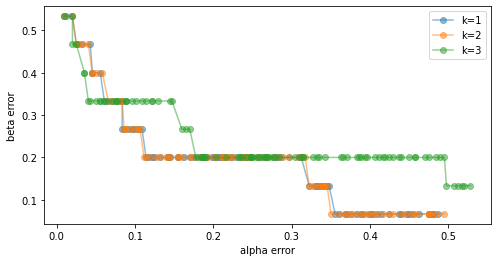

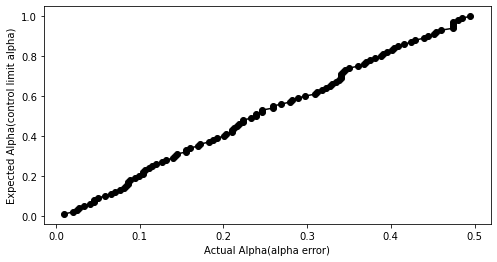

In [18]:
# visualization of obtcbm
optcbmPlot(searchOptCBM, save=False)

In [19]:
# alpha (control limit 유의수준)와 alpha error, beta error
searchOptCBM

array([[[0.01      , 0.01015228, 0.53333333],
        [0.02      , 0.01269036, 0.53333333],
        [0.03      , 0.02030457, 0.53333333],
        [0.04      , 0.02538071, 0.46666667],
        [0.05      , 0.02791878, 0.46666667],
        [0.06      , 0.03299492, 0.46666667],
        [0.07      , 0.04314721, 0.46666667],
        [0.08      , 0.04568528, 0.4       ],
        [0.09      , 0.04568528, 0.4       ],
        [0.1       , 0.05583756, 0.4       ],
        [0.11      , 0.06091371, 0.33333333],
        [0.12      , 0.06598985, 0.33333333],
        [0.13      , 0.07106599, 0.33333333],
        [0.14      , 0.07614213, 0.33333333],
        [0.15      , 0.08375635, 0.33333333],
        [0.16      , 0.08375635, 0.33333333],
        [0.17      , 0.08375635, 0.26666667],
        [0.18      , 0.08629442, 0.26666667],
        [0.19      , 0.09137056, 0.26666667],
        [0.2       , 0.0964467 , 0.26666667],
        [0.21      , 0.09898477, 0.26666667],
        [0.22      , 0.10406091, 0

In [20]:
# optimal CBM with cluster k = 2
optCbm = cbm(hcn7_train.drop(['PassOrFail'], axis=1), cn7_test.drop(['PassOrFail'], axis=1), n_clusters=2, max_iter=100)

# alpha error가 0.2일때 최적
optAlpha = searchOptCBM[2,60,0]

# control limit
optHealthyCbm = cbm(hcn7_train.drop(['PassOrFail'], axis=1),hcn7_train.drop(['PassOrFail'], axis=1), n_clusters=2, max_iter=100)
cl = bootstrap_limit(optHealthyCbm['cbm'], alpha = optAlpha)

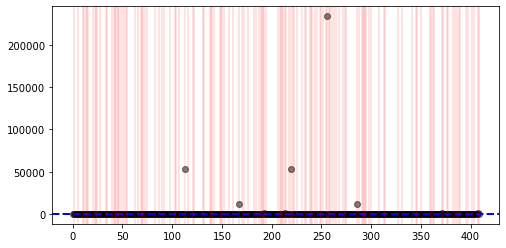

In [21]:
# visualization of the Anomaly detection
AnomalyPlot(optCbm['cbm'], cl, main_alpha=0.5, alarm_alpha=0.15, save=False)

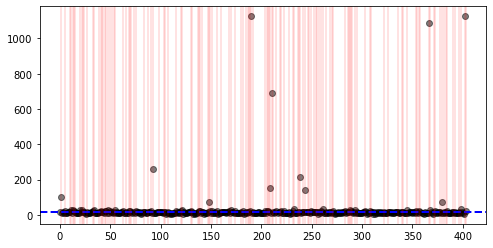

In [22]:
# 극 이상치 (위에서 3개의 극 이상치)가 제거된 이상감지 시각화
AnomalyPlot(optCbm['cbm'][np.where(optCbm['cbm']<5000)[0]], cl, main_alpha=0.5, alarm_alpha=0.15, save=False)

In [23]:
# False Alarm Classificatoin 성능 검증을 위한 Validation dataset 사용 (False Alarm Classification Model에서 Train모델로 사용됨)
validCBM =cbm(hcn7_train.drop(['PassOrFail'], axis=1),cn7_valid.drop(['PassOrFail'], axis=1), n_clusters=2, max_iter=100)
overCL_validdat = cn7_valid[validCBM['cbm']>cl]
overCL_validdat = overCL_validdat.reset_index(drop=True)
overCL_validdat['PassOrFail'] = overCL_validdat['PassOrFail'].astype('category')

In [24]:
# False Alarm Classification Model에서 Test데이터로 사용됨
overCL_testdat = cn7_test[optCbm['cbm']>cl]
overCL_testdat=overCL_testdat.reset_index(drop=True)
overCL_testdat['PassOrFail'] = overCL_testdat['PassOrFail'].astype('category')

In [25]:
overCLdat_valid_X = overCL_validdat.drop(['PassOrFail'], axis=1)
overCLdat_valid_Y = overCL_validdat['PassOrFail']

overCLdat_test_X = overCL_testdat.drop(['PassOrFail'], axis=1)
overCLdat_test_Y = overCL_testdat['PassOrFail']

In [26]:
## False Alarm Classification
# Optimizied Decision Tree
# average_precision
optdt = optDT(overCLdat_valid_X,overCLdat_valid_Y, meausre='balanced_accuracy')

# best model fits
dt_pred = optdt.predict(overCLdat_test_X)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.9250
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


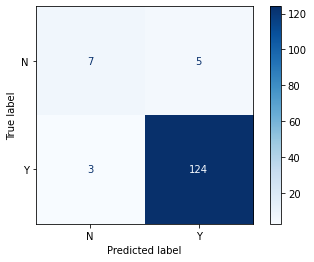

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(optdt, # 분류 모델
                             overCLdat_test_X, overCLdat_test_Y, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=['N','Y'], # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None, # 'true', 'pred', 'all' 중에서 지정 가능. default=None
                     )      
plt.show()

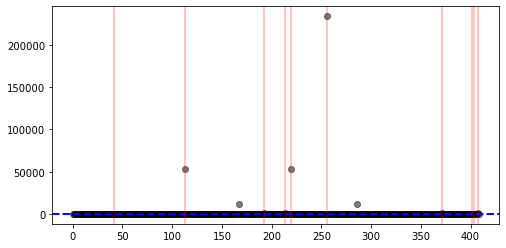

In [28]:
## False Alarm Classification을 활용한 False alarm 제거 후 모니터링 결과
# False Alarm 제거 후 이상감지 결과
delFalseAlarmAnomalyPlot(optCbm['cbm'], cl, dt_pred, main_alpha = 0.5, alarm_alpha=0.3, save=False)

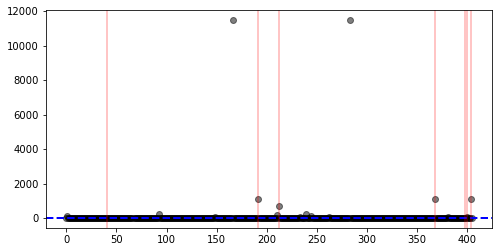

In [29]:
# False Alarm 제거 후 이상감지 결과 (극 이상치 제거 결과)
delFalseAlarmAnomalyPlot(optCbm['cbm'][np.where(optCbm['cbm']<20000)[0]], cl, dt_pred[optCbm['cbm'][optCbm['cbm']>cl].reset_index(drop=True)<20000], main_alpha = 0.5, alarm_alpha=0.3, save=False)

In [30]:
# False Alarm Classification 적용 전 alpha error, beta error
befFAC_alpha_error = (cn7_test['PassOrFail'][np.where(optCbm['cbm']>cl)[0]] == 'Y').sum()/(cn7_test['PassOrFail']=='Y').sum()
befFAC_beta_error = (cn7_test['PassOrFail'][np.where(optCbm['cbm']<cl)[0]] == 'N').sum()/(cn7_test['PassOrFail']=='N').sum()

# False Alarm Classification 적용 후 alpha error, beta error
alpha_error = confusion_matrix(overCLdat_test_Y, dt_pred)[1][0]/(cn7_test['PassOrFail']=='Y').sum()
beta_error = confusion_matrix(overCLdat_test_Y, dt_pred)[0][1]/(cn7_test['PassOrFail']=='N').sum()

print('False Alarm Classification 적용 전 결과')
print('alphaError : %f' %befFAC_alpha_error)
print('betaError : %f' %befFAC_beta_error)
print()
print('False Alarm Classification 적용 후 결과')
print('alphaError : %f' %alpha_error)
print('betaError : %f' %beta_error)

False Alarm Classification 적용 전 결과
alphaError : 0.320707
betaError : 0.076923

False Alarm Classification 적용 후 결과
alphaError : 0.007576
betaError : 0.384615


<b><h2>성능 평가를 위한 반복 시행 </h2></b>

In [56]:
# 성능평가를 위한 반복시행 (30번 반복시행)
# Train : Valid : Test = 0.6 : 0.2 : 0.2
alpha_list=[0.05, 0.2, 0.7]
k_list = [1,2,3]
befFAC_result = np.zeros((3, 30,3,3)) # k, iteration, alpha,alpha_error, beta_error
FAC_result = np.zeros((3, 30,3,3)) # k, iteration, alpha,alpha_error, beta_error
for k in range(len(k_list)): # cluster k
    for i in range(30): # iteration
        for j in range(len(alpha_list)): # alpha
            hcn7_train, hcn7_X_valid_test= train_test_split(healthy_CN7, test_size=0.2)
            cn7_valid, cn7_test= train_test_split(pd.concat([hcn7_X_valid_test, outlier_CN7], axis=0), test_size=0.5)

            # train : 정상, valid : 정상/이상, test : 정상/이상 데이터
            hcn7_train=hcn7_train.reset_index(drop=True)
            cn7_valid=cn7_valid.reset_index(drop=True)
            cn7_test=cn7_test.reset_index(drop=True)

            # searchOptCBM = optCBM(hcn7_train.drop(['PassOrFail'], axis=1), cn7_valid.drop(['PassOrFail'], axis=1), labels =cn7_valid['PassOrFail'], n_clusters=3)

            # optimal CBM with cluster k = 2
            optCbm = cbm(hcn7_train.drop(['PassOrFail'], axis=1), cn7_test.drop(['PassOrFail'], axis=1), n_clusters=k_list[k], max_iter=100)

            # control limit
            optHealthyCbm = cbm(hcn7_train.drop(['PassOrFail'], axis=1),hcn7_train.drop(['PassOrFail'], axis=1), n_clusters=k_list[k], max_iter=100)
            cl = bootstrap_limit(optHealthyCbm['cbm'], alpha = alpha_list[j])

            # False Alarm Classificatoin 성능 검증을 위한 Validation dataset 사용 (False Alarm Classification Model에서 Train모델로 사용됨)
            validCBM =cbm(hcn7_train.drop(['PassOrFail'], axis=1),cn7_valid.drop(['PassOrFail'], axis=1), n_clusters=k_list[k], max_iter=100)
            overCL_validdat = cn7_valid[validCBM['cbm']>cl]
            overCL_validdat = overCL_validdat.reset_index(drop=True)
            overCL_validdat['PassOrFail'] = overCL_validdat['PassOrFail'].astype('category')

            # False Alarm Classification Model에서 Test데이터로 사용됨
            overCL_testdat = cn7_test[optCbm['cbm']>cl]
            overCL_testdat=overCL_testdat.reset_index(drop=True)
            overCL_testdat['PassOrFail'] = overCL_testdat['PassOrFail'].astype('category')

            overCLdat_valid_X = overCL_validdat.drop(['PassOrFail'], axis=1)
            overCLdat_valid_Y = overCL_validdat['PassOrFail']

            overCLdat_test_X = overCL_testdat.drop(['PassOrFail'], axis=1)
            overCLdat_test_Y = overCL_testdat['PassOrFail']

            ## False Alarm Classification
            # Optimizied Decision Tree
            # average_precision
            optdt = optDT(overCLdat_valid_X,overCLdat_valid_Y, meausre='balanced_accuracy')

            # best model fits
            dt_pred = optdt.predict(overCLdat_test_X)

            # False Alarm Classification 적용 전 alpha error, beta error
            befFAC_alpha_error = (cn7_test['PassOrFail'][np.where(optCbm['cbm']>cl)[0]] == 'Y').sum()/(cn7_test['PassOrFail']=='Y').sum()
            befFAC_beta_error = (cn7_test['PassOrFail'][np.where(optCbm['cbm']<cl)[0]] == 'N').sum()/(cn7_test['PassOrFail']=='N').sum()
 
            # False Alarm Classification 적용 후 alpha error, beta error
            alpha_error = confusion_matrix(overCLdat_test_Y, dt_pred)[1][0]/(cn7_test['PassOrFail']=='Y').sum()
            beta_error = confusion_matrix(overCLdat_test_Y, dt_pred)[0][1]/(cn7_test['PassOrFail']=='N').sum()
            
            befFAC_result[k][i][j][0] = alpha_list[j]
            befFAC_result[k][i][j][1] = befFAC_alpha_error
            befFAC_result[k][i][j][2] = befFAC_beta_error
            
            FAC_result[k][i][j][0] = alpha_list[j]
            FAC_result[k][i][j][1] = alpha_error
            FAC_result[k][i][j][2] = beta_error

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8633
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8833
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7349
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8222
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6473
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 20}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7944
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9271
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8375
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8551
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7450
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8804
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8139
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8402
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7071
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9632
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8567
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8604
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8125
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8212
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 20}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7833
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8510
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8375
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7488
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not

GridSearchCV 최고 평균 정확도 수치: 0.6818
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8548
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8357
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6554
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 23}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 26}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6600
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7590
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 25}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 25}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7794
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8383
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 23}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7958
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7931
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7692
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8417
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7833
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 26}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6464
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6960
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8050
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not

GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8250
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8702
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8857
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7583
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8417
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6564
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8611
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 23}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7923
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9033
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7440
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 23}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7486
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8056
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.5048
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9437
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9456
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 21}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6180
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6690
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6229
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8042
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8343
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8639
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7124
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8714
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8467
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7936
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 20}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8440
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8357
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7988
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not

GridSearchCV 최고 평균 정확도 수치: 0.5667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7815
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9283
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8498
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7929
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7598
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not

GridSearchCV 최고 평균 정확도 수치: 0.7333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7556
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 23}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8741
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9300
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 27}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8786
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 25}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8862
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7917
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7926
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9083
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9187
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.6500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8571
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8429
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7278
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8630
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6556
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6698
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8625
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8880
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7619
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8867
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 28}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8636
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7393
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7956
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7704
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6773
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6926
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 25}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8569
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8976
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7357
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8250
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8300
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6229
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6429
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 21}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8098
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7625
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8296
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8300
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 28}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8354
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8571
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9193
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8058
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 27}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8289
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8048
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9467
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8394
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8833
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8250
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8208
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9563
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8889
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8300
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.5722
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8967
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8542
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8348
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 18}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8430
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7357
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8255
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9083
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9133
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7400
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9466
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7818
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 19}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7931
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8889
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8227
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8900
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7956
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7764
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 13}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8800
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 20}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8943
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.6500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8389
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8529
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not

GridSearchCV 최고 평균 정확도 수치: 0.7000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7132
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8405
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 6}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7790
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 20}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8917
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8278
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8430
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9289
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 9}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8625
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8042
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 26}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7667
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 11}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8242
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.6750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 15}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8778
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8966
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 27}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8900
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 7}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.7933
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 17}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9233
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8167
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.9500
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 22}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 1.0000
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8273
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 12}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV 최고 평균 정확도 수치: 0.8250
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


GridSearchCV 최고 평균 정확도 수치: 0.8750
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 14}
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.9333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 24}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


In [149]:
# iter
# k, iteration, alpha,alpha_error, beta_error
beFAC_perf = np.zeros((3,3,3))
FAC_perf = np.zeros((3,3,3))
for k in range(3):
    for i in range(30):
        beFAC_perf[k] += befFAC_result[k][i]
for k in range(3):
    for i in range(30):
        FAC_perf[k] += FAC_result[k][i]
        
beFAC_score = beFAC_perf/30
FAC_score = FAC_perf/30

In [159]:
# cluster k 별 alpha, alphaError, betaError
FAC_score
beFAC_score

array([[[0.05      , 0.02444748, 0.388639  ],
        [0.2       , 0.10240107, 0.27844053],
        [0.7       , 0.3636474 , 0.11037371]],

       [[0.05      , 0.0280019 , 0.38063066],
        [0.2       , 0.1074049 , 0.26933672],
        [0.7       , 0.3596497 , 0.08667553]],

       [[0.05      , 0.02804483, 0.3718395 ],
        [0.2       , 0.10985444, 0.28411923],
        [0.7       , 0.37063003, 0.13841866]]])

In [160]:
score = np.zeros((3,100,3))
for i in range(30):
            hcn7_train, hcn7_X_valid_test= train_test_split(healthy_CN7, test_size=0.2)
            cn7_valid, cn7_test= train_test_split(pd.concat([hcn7_X_valid_test, outlier_CN7], axis=0), test_size=0.5)

            # train : 정상, valid : 정상/이상, test : 정상/이상 데이터
            hcn7_train=hcn7_train.reset_index(drop=True)
            cn7_valid=cn7_valid.reset_index(drop=True)
            cn7_test=cn7_test.reset_index(drop=True)
            
            searchOptCBM = optCBM(hcn7_train.drop(['PassOrFail'], axis=1), cn7_valid.drop(['PassOrFail'], axis=1), labels =cn7_valid['PassOrFail'], n_clusters=3)
            score = score+searchOptCBM

-------------
k=1
AUC=0.112300
-------------
-------------
k=2
AUC=0.113400
-------------
-------------
k=3
AUC=0.148500
-------------
-------------
k=1
AUC=0.051200
-------------
-------------
k=2
AUC=0.050600
-------------
-------------
k=3
AUC=0.076600
-------------
-------------
k=1
AUC=0.106300
-------------
-------------
k=2
AUC=0.103500
-------------
-------------
k=3
AUC=0.119800
-------------
-------------
k=1
AUC=0.114400
-------------
-------------
k=2
AUC=0.111100
-------------
-------------
k=3
AUC=0.144100
-------------
-------------
k=1
AUC=0.124800
-------------
-------------
k=2
AUC=0.123600
-------------
-------------
k=3
AUC=0.154900
-------------
-------------
k=1
AUC=0.182100
-------------
-------------
k=2
AUC=0.179200
-------------
-------------
k=3
AUC=0.231100
-------------
-------------
k=1
AUC=0.094100
-------------
-------------
k=2
AUC=0.095300
-------------
-------------
k=3
AUC=0.120400
-------------
-------------
k=1
AUC=0.101200
-------------
----------

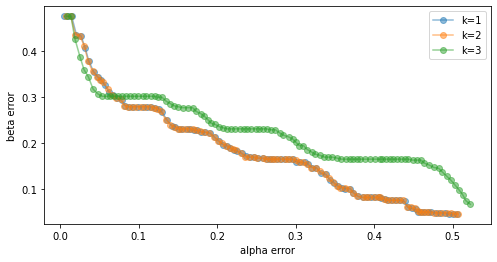

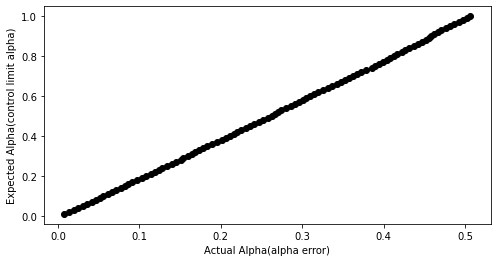

In [161]:
# visualization of obtcbm
optcbmPlot(score/30, save=True)